In [74]:
import gym
import time
import torch
import matplotlib.pyplot as plt

plt.style.use('ggplot')

## Q-learning
First off applying the most well-known _tabular_, _one-step_ TD method originally introduced by [(Watkins, 1989)](https://www.gatsby.ucl.ac.uk/~dayan/papers/cjch.pdf). Which learns the $Q$ function using bootstrapping, the update rule is defined as,

\begin{align}
Q_t(s, a) &\leftarrow Q_{t-1}(s, a) - a \cdot \text{TD} \\
&\leftarrow Q(s, a)+\alpha \left[r+\gamma * \max _{a^{\prime}} Q\left(s^{\prime}, a^{\prime}\right)-Q(s, a)\right] \\
&\leftarrow(1-\alpha) Q(s, a)+\alpha \left[r+\gamma * \max _{a^{\prime}} Q\left(s^{\prime}, a^{\prime}\right)\right]
\end{align}

### Q-learning in a deterministic environment

Also named off-policy TD control for estimating the policy, can be found in chapter 6.5 by Barto & Sutton. The reason that Q-learning is off-policy is that it updates its Q-values using the Q-value of the next state 𝑠′ and the greedy action 𝑎′. In other words, it estimates the return (total discounted future reward) for state-action pairs assuming a greedy policy were followed despite the fact that it's not following a greedy policy.

# <img src="../img/Q-learning_CH6.5.png">

In [62]:
def print_statistics(Q, num_episodes, rewards_total, steps_total, eps_decay=None, Q_2=None):
    if Q_2 is not None:
        print("Q_1-function:", Q)
        print("Q_2-function:", Q_2)
    else:
        print("Q-function:", Q)
    
    print("Percentage of episodes finished succesfully: {0}".format(
        sum(rewards_total)/num_episodes))
    print("Percentage of episodes finished succesfully (last 100 episodes): {0}".format(
        sum(rewards_total[-100:])/100))

    print("Average number of steps: %.2f" % (sum(steps_total)/num_episodes))
    print("Average number of steps (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))

    plt.figure(figsize=(12, 5))
    plt.title("Rewards")
    plt.ylabel("Episode length")
    plt.xlabel("Episode")
    plt.bar(np.arange(len(rewards_total)), rewards_total, alpha=0.6, color='green')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.title("Steps")
    plt.ylabel("Episode length")
    plt.xlabel("Episode")
    plt.bar(np.arange(len(steps_total)), steps_total, alpha=0.6, color='red')
    plt.show()
    
    if eps_decay is not None:
        plt.figure(figsize=(12, 5))
        plt.title("$\epsilon$-greedy values")
        plt.ylabel("$\epsilon$ values")
        plt.xlabel("Episode")
        plt.bar(np.arange(len(eps_decay)), eps_decay, alpha=0.6, color='blue')
        plt.show()

Episode finished after 10 steps, with reward 1
Episode finished after 6 steps, with reward 1
Episode finished after 6 steps, with reward 1
Episode finished after 6 steps, with reward 1
Episode finished after 6 steps, with reward 1
Episode finished after 6 steps, with reward 1
Episode finished after 6 steps, with reward 1
Episode finished after 6 steps, with reward 1
Episode finished after 6 steps, with reward 1
Episode finished after 6 steps, with reward 1
Q-function: tensor([[0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1061, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4658, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000

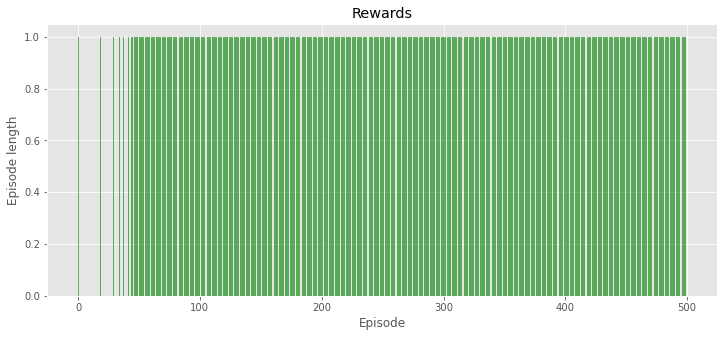

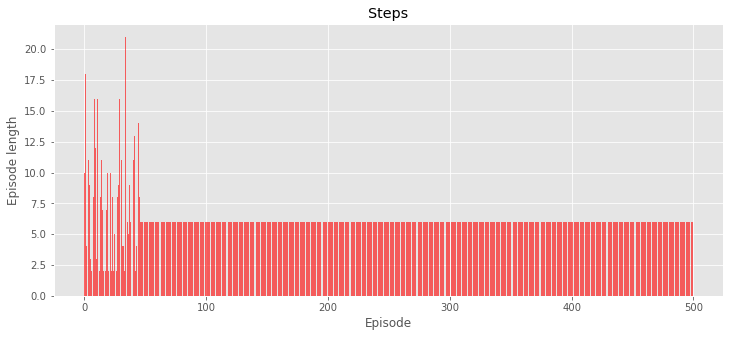

In [75]:
# Creating a deterministic environment by having the environment being not slippery
env = gym.make('FrozenLake-v0', is_slippery=False)

def Q_learning(env, num_episodes=500, gamma=1, alpha=0.8, print_i=50):
    nS = env.observation_space.n
    nA = env.action_space.n
    rewards_total = []
    steps_total = []

    # Q-function estimate
    Q = torch.zeros([nS, nA])

    # Loop for each episode
    for i in range(num_episodes):
        # Initiatize S
        observation = env.reset()
        steps = 0

        while True:
            steps += 1

            # Choose next A from S using policy derived from Q
            # Adding randomness to keep exploration
            random_values = Q[observation] + torch.randn(1, nA)/1000
            action = torch.argmax(random_values).item()

            # Take action A, observce R, S'
            new_observation, reward, done, info = env.step(action)

            # Q(S, A) <- Q(S, A) + alpha[R + gamma max_a(S', a) - Q(S, A)]
            Q[observation, action] += alpha * (reward + gamma * 
                                               torch.max(Q[new_observation]).item() - Q[observation, action])
            
            # S <- S'
            observation = new_observation        

            # Terminate if environment is done
            if done:
                # Store statistics
                steps_total.append(steps)
                rewards_total.append(reward)
                if i % print_i == 0:
                    print("Episode finished after %i steps, with reward %i" % (steps, reward))
                break
    
    print_statistics(Q, num_episodes, rewards_total, steps_total)
    
Q_learning(env, alpha=0.4)

### Q-Learning in stochastic environment

This shows how much harder the environment gets if it becomes stochastic, e.g. there is a chance for the agent to slip into a hole in the environment.

Episode finished after 10 steps, with reward 0
Episode finished after 10 steps, with reward 1
Episode finished after 100 steps, with reward 0
Episode finished after 78 steps, with reward 1
Episode finished after 24 steps, with reward 0
Episode finished after 22 steps, with reward 0
Episode finished after 28 steps, with reward 1
Episode finished after 19 steps, with reward 0
Q-function: tensor([[6.0335e-01, 4.0404e-04, 7.6095e-04, 2.2475e-03],
        [0.0000e+00, 2.8289e-03, 0.0000e+00, 6.9036e-01],
        [4.3298e-01, 1.0209e-03, 3.0281e-03, 5.4693e-04],
        [5.3055e-04, 8.0841e-05, 7.9099e-05, 5.3355e-04],
        [5.7381e-01, 9.0966e-05, 7.3509e-05, 2.7675e-04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [6.2508e-05, 9.8743e-07, 3.0635e-01, 4.5937e-11],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.4165e-04, 4.0600e-04, 0.0000e+00, 5.6885e-01],
        [0.0000e+00, 7.6091e-01, 2.5823e-04, 0.0000e+00],
        [3.0276e-01, 3.9759e-04

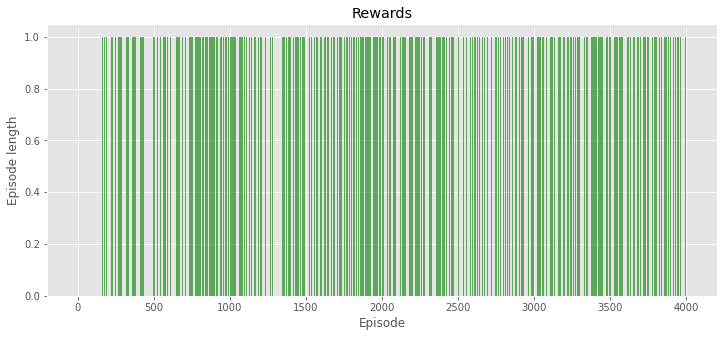

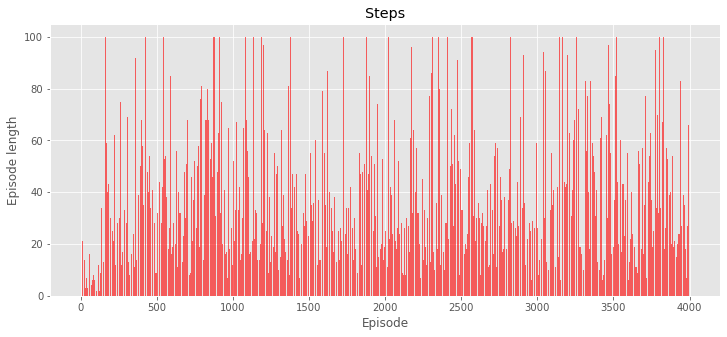

In [65]:
env = gym.make('FrozenLake-v0')

# training it on a stochastic environment
Q_learning(env, num_episodes=4000, gamma=0.99, alpha=0.85, print_i=500)

Note that the agent only completes about 58% of the runs succesfully now, making the environment stochastic makes it a lot harder for the agent to solve the environment.

### Applying $\epsilon$-greedy exploration to Q-Learning in stochastic environment
Now applying an exploration technique to keep exploring the environment, $\epsilon$-greedy,

\begin{align}
a=\left\{\begin{array}{ll}\text {optimal } a^{*} & 1-\varepsilon \\ \text {random} & \varepsilon\end{array}\right.
\end{align}

As we now keep exploring, we will sometimes not terminate all episodes succesfully. 

Episode finished after 8 steps, with reward 0
Episode finished after 22 steps, with reward 0
Episode finished after 21 steps, with reward 1
Episode finished after 47 steps, with reward 1
Episode finished after 44 steps, with reward 1
Episode finished after 2 steps, with reward 0
Episode finished after 100 steps, with reward 0
Episode finished after 86 steps, with reward 1
Episode finished after 8 steps, with reward 0
Episode finished after 4 steps, with reward 0
Q-function: tensor([[0.6200, 0.3468, 0.4420, 0.4234],
        [0.2226, 0.2451, 0.1585, 0.5174],
        [0.3897, 0.1823, 0.2300, 0.3095],
        [0.1439, 0.1531, 0.2554, 0.2705],
        [0.6951, 0.5926, 0.3451, 0.3385],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0139, 0.0018, 0.2488, 0.0075],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.3024, 0.2720, 0.2712, 0.6983],
        [0.1922, 0.8100, 0.4685, 0.1381],
        [0.3625, 0.0801, 0.1753, 0.1433],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 

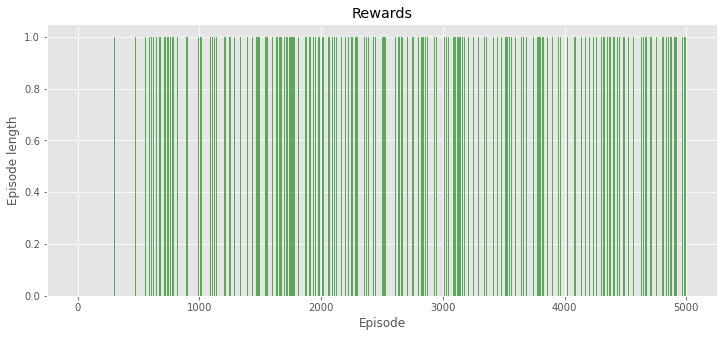

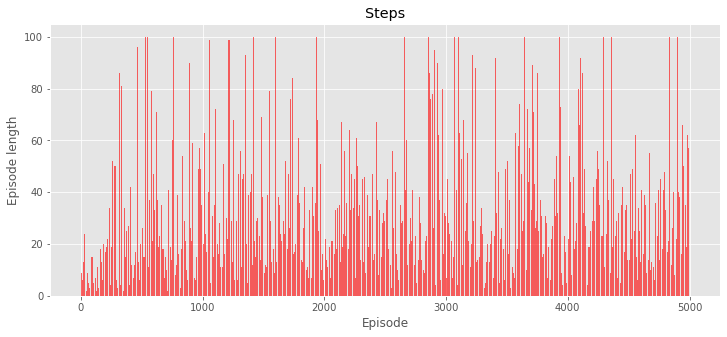

In [66]:
def Q_learning(env, num_episodes=500, gamma=1, alpha=0.8, epsilon = 0.1, print_i=50):
    nS = env.observation_space.n
    nA = env.action_space.n
    rewards_total = []
    steps_total = []

    # Q-function estimate
    Q = torch.zeros([nS, nA])

    # Loop for each episode
    for i in range(num_episodes):
        # Initiatize S
        observation = env.reset()
        steps = 0

        while True:
            steps += 1

            # Choose next A from S using policy derived from Q,
            # Using an epsilon-greedy exploration technique
            random_val = torch.rand(1)[0].item()
            if random_val > epsilon:
                random_values = Q[observation] + torch.randn(1, nA)/1000
                action = torch.argmax(random_values).item()
            else:
                action = env.action_space.sample()

            # Take action A, observce R, S'
            new_observation, reward, done, info = env.step(action)

            # Q(S, A) <- Q(S, A) + alpha[R + gamma max_a(S', a) - Q(S, A)]
            Q[observation, action] += alpha * (reward + gamma * torch.max(
                Q[new_observation]).item() - Q[observation, action])

            # S <- S'
            observation = new_observation        

            # Terminate if environment is done
            if done:
                # Store statistics
                steps_total.append(steps)
                rewards_total.append(reward)
                if i % print_i == 0:
                    print("Episode finished after %i steps, with reward %i" % (steps, reward))
                break

    print_statistics(Q, num_episodes, rewards_total, steps_total)

Q_learning(env, num_episodes=5000, gamma=0.99, alpha=0.45, epsilon=0.05, print_i=500)

We will now, adjust our exploration function by introducing $\epsilon$-greedy with decay, to reduce the exploration the more episodes have been finished as the environment is sufficiently explored.

Episode finished after 14 steps, with reward 1
Episode finished after 15 steps, with reward 1
Episode finished after 100 steps, with reward 0
Episode finished after 100 steps, with reward 0
Episode finished after 35 steps, with reward 1
Episode finished after 6 steps, with reward 0
Episode finished after 72 steps, with reward 1
Episode finished after 47 steps, with reward 1
Episode finished after 34 steps, with reward 1
Episode finished after 23 steps, with reward 1
Q-function: tensor([[4.7838e-01, 3.8646e-01, 4.2939e-01, 3.9391e-01],
        [1.4683e-01, 2.7062e-01, 2.9591e-01, 4.8077e-01],
        [2.1160e-01, 2.9450e-01, 3.1367e-01, 3.9462e-01],
        [1.8243e-01, 3.0638e-01, 1.8114e-01, 3.2583e-01],
        [4.9465e-01, 2.3865e-01, 3.8746e-01, 3.6851e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.5166e-02, 1.0578e-02, 4.5884e-01, 6.7895e-04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.2750e-01, 4.0411e-01, 4.2110e-01, 5.0609e-

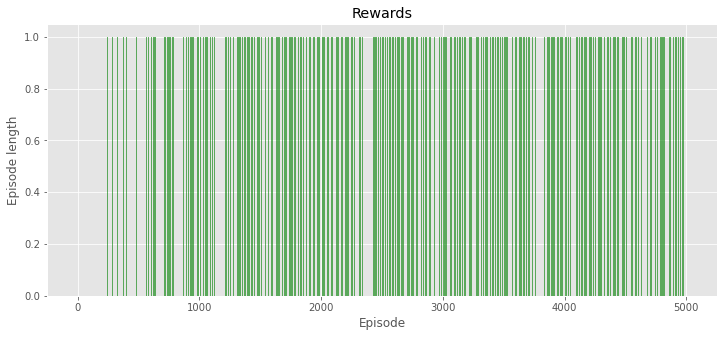

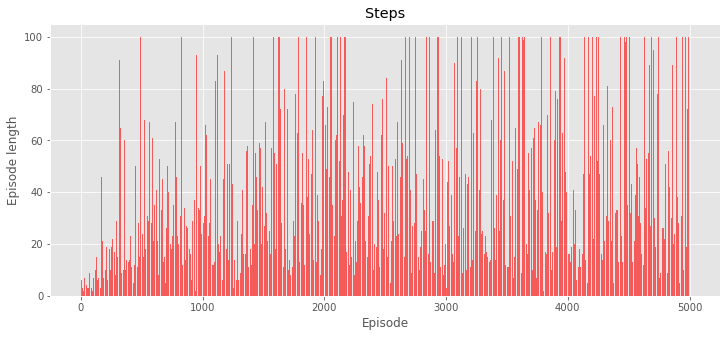

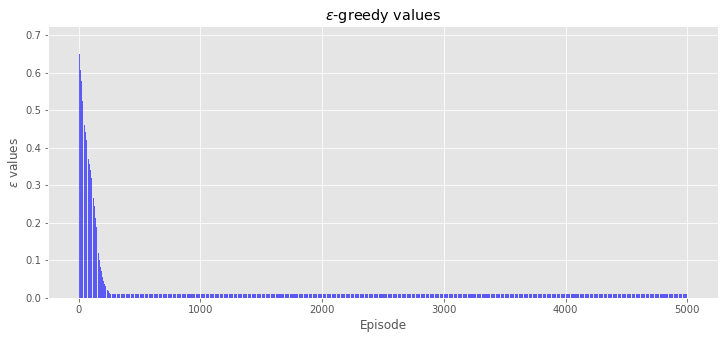

In [67]:
def Q_learning(env, num_episodes=500, gamma=1, alpha=0.8, epsilon = 0.1, print_i=50):
    nS = env.observation_space.n
    nA = env.action_space.n
    
    # tracking statistics
    rewards_total = []
    steps_total = []
    egreedy_total = []

    # Q-function estimate
    Q = torch.zeros([nS, nA])
    
    epsilon_final = 0.01
    epsilon_decay = 0.999

    # Loop for each episode
    for i in range(num_episodes):
        # Initiatize S
        observation = env.reset()
        steps = 0

        while True:
            steps += 1

            # Choose next A from S using policy derived from Q,
            # Using an epsilon-greedy exploration technique
            random_val = torch.rand(1)[0].item()
            if random_val > epsilon:
                random_values = Q[observation] + torch.randn(1, nA)/1000
                action = torch.argmax(random_values).item()
            else:
                action = env.action_space.sample()

            if epsilon > epsilon_final:
                epsilon *= epsilon_decay

            # Take action A, observce R, S'
            new_observation, reward, done, info = env.step(action)

            # Q(S, A) <- Q(S, A) + alpha[R + gamma max_a(S', a) - Q(S, A)]
            Q[observation, action] += alpha * (reward + gamma * torch.max(
                Q[new_observation]).item() - Q[observation, action])

            # S <- S'
            observation = new_observation        

            # Terminate if environment is done
            if done:
                # Store statistics
                steps_total.append(steps)
                rewards_total.append(reward)
                egreedy_total.append(epsilon)
                if i % print_i == 0:
                    print("Episode finished after %i steps, with reward %i" % (steps, reward))
                break

    print_statistics(Q, num_episodes, rewards_total, steps_total, egreedy_total)

Q_learning(env, num_episodes=5000, gamma=0.99, alpha=0.45, epsilon=0.7, print_i=500)

### Double Q-Learning
Due to the maximum operator in the TD update of Q-learning, a _maximization bias_ is induced. In other words, due to always considering the maximum state we will always overestimate the value of an action resulting in a positive bias. Hence, the introduction of _double Q-learning_, using two independent estimators to determine the maximizing action $A^* = \arg \max_a Q_1(a)$, and the other, $Q_2$, to provide the estimate of its value $Q_2(A^*) = Q_2(\arg max_a Q_1(a))$. This estimate will then be unbiased in the sense that $\mathbb{E}\left[Q_{2}\left(A^{*}\right)\right]=q\left(A^{*}\right)$.

# <img src="../img/double-Q-learning_CH6.7.png">

Episode finished after 9 steps, with reward 0
Episode finished after 8 steps, with reward 1
Episode finished after 8 steps, with reward 1
Episode finished after 6 steps, with reward 1
Episode finished after 12 steps, with reward 1
Q_1-function: tensor([[1.0000, 0.9950, 1.0000, 1.0000],
        [1.0000, 0.0000, 0.0000, 0.8000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.9764],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.9600, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.9907, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8000, 1.0000, 0.4096],
        [0.8000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])
Q_2-function: tensor([[1.0000, 1.0000, 0.9970, 1.0000],
        [1.0000, 0.0000, 0

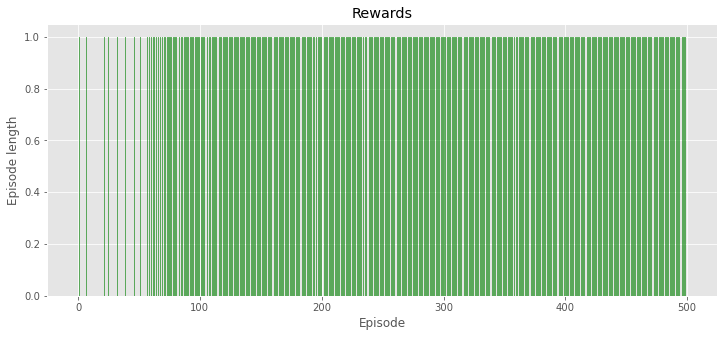

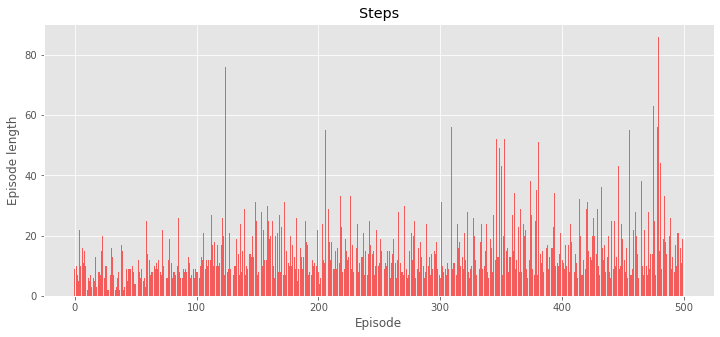

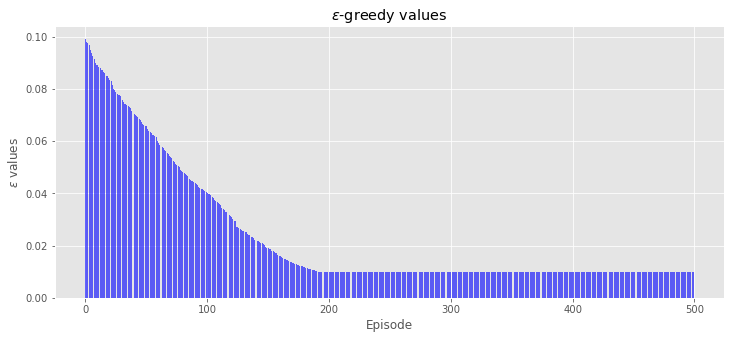

In [71]:
env = gym.make('FrozenLake-v0', is_slippery=False)

def double_Q_learning(env, num_episodes=500, gamma=1, alpha=0.8, epsilon = 0.1, print_i=50):
    nS = env.observation_space.n
    nA = env.action_space.n
    
    # tracking statistics
    rewards_total = []
    steps_total = []
    egreedy_total = []

    # Q-function estimate
    Q = torch.zeros([nS, nA])
    
    epsilon_final = 0.01
    epsilon_decay = 0.999

    # Bernoulli trials to decide estimators
    bernoulli_trial = lambda : int(torch.bernoulli(torch.Tensor([0.5])).item()) == 1
    Q1 = torch.zeros([nS, nA])
    Q2 = torch.zeros([nS, nA])

    # Loop for each episode
    for i in range(num_episodes):
        # Initiatize S
        observation = env.reset()
        steps = 0

        while True:
            steps += 1
            bernoulli_result = bernoulli_trial()

            # Choose next A from S using policy derived from Q,
            # Using an epsilon-greedy technique
            random_val = torch.rand(1)[0].item()
            if random_val > epsilon:
                if bernoulli_result:
                    random_values = Q1[observation] + torch.randn(1, nA)/1000
                    action = torch.argmax(random_values).item()
                else:
                    random_values = Q2[observation] + torch.randn(1, nA)/1000
                    action = torch.argmax(random_values).item()
            else:
                action = env.action_space.sample()

            if epsilon > epsilon_final:
                epsilon *= epsilon_decay

            # Take action A, observce R, S'
            new_observation, reward, done, info = env.step(action)

            # With 0.5 probability,
            if bernoulli_result:
                # Q_1(S, A) <- Q_1(S, A) + alpha[R + gamma Q_2(max_a(S', a)) - Q_1(S, A)]
                Q1[observation, action] += alpha * (reward + gamma * torch.max(
                    Q2[new_observation]).item() - Q1[observation, action])
            else:
                # Q_2(S, A) <- Q_2(S, A) + alpha[R + gamma Q_1(max_a(S', a)) - Q_2(S, A)]
                Q2[observation, action] += alpha * (reward + gamma * torch.max(
                    Q1[new_observation]).item() - Q2[observation, action])

            # S <- S'
            observation = new_observation

            # Terminate if environment is done
            if done:
                # Store statistics
                steps_total.append(steps)
                rewards_total.append(reward)
                egreedy_total.append(epsilon)
                if i % print_i == 0:
                    print("Episode finished after %i steps, with reward %i" % (steps, reward))
                break


    print_statistics(Q1, num_episodes, rewards_total, steps_total, egreedy_total, Q2)
    
double_Q_learning(env, print_i=100)

Episode finished after 8 steps, with reward 0
Episode finished after 22 steps, with reward 1
Episode finished after 26 steps, with reward 0
Episode finished after 13 steps, with reward 0
Episode finished after 100 steps, with reward 0
Q_1-function: tensor([[3.4208e-01, 4.3697e-01, 3.1439e-01, 4.1664e-01],
        [1.3738e-01, 5.2639e-03, 3.0581e-01, 4.4955e-01],
        [2.6722e-01, 8.2190e-02, 2.2738e-01, 3.8624e-01],
        [1.6395e-02, 7.7885e-02, 5.1084e-03, 3.8345e-01],
        [5.2970e-01, 1.0251e-01, 7.4931e-02, 2.8100e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.9355e-02, 1.7984e-05, 1.2795e-03, 4.9532e-05],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.1712e-01, 9.0898e-02, 1.4797e-01, 6.1816e-01],
        [1.5634e-01, 2.6882e-01, 5.2255e-02, 1.6933e-01],
        [1.5195e-01, 1.0376e-03, 5.2950e-03, 5.8312e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00

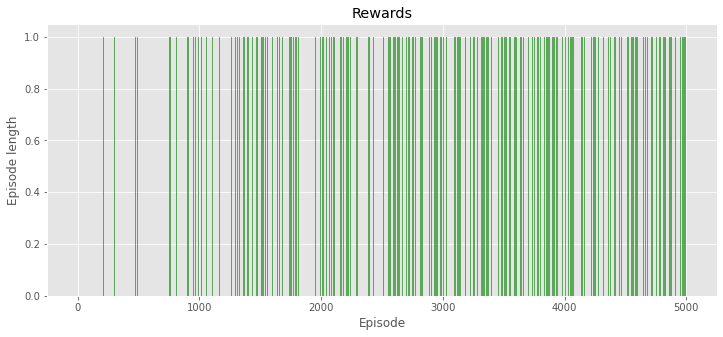

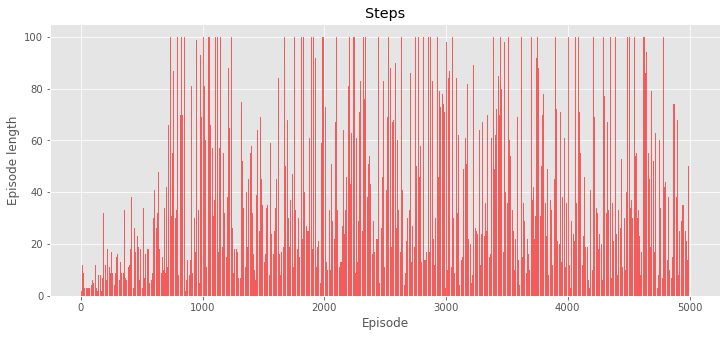

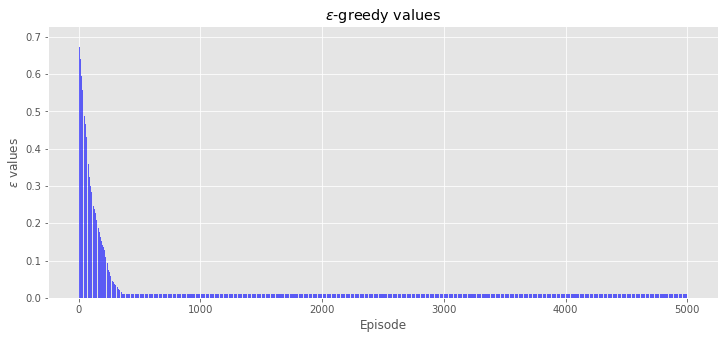

In [73]:
env = gym.make('FrozenLake-v0')
double_Q_learning(env, num_episodes=5000, gamma=0.99, alpha=0.75, epsilon=0.7, print_i=1000)